# ts_for_multi_armed_bandit

## Demonstration of Thompson Sampling for the Multi-Armed Bandit Problem

In this Notebook, let us introduce the Multi-Armed Bandit problem and compare some decision policies like $\epsilon$-greedy, UCB, and our contestant Thompson Sampling.

In [1]:
# plotting inline
%matplotlib inline

# working directory
import os; os.chdir('/home/gdmarmerola/ts_demo')

# importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta as beta_dist
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm

# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('fivethirtyeight')

## Problem: The Binomial Bandit

The  Multi-Armed Bandit problem is the simplest setting of reinforcement learning. Suppose that a gambler faces a row of slot machines (bandits) on a casino. Each one of the $K$ machines has a probability $\theta_k$ of providing a reward to the player. Thus, the player has to decide which machines to play, how many times to play each machine and in which order to play them, in order to maximize his cumulative reward. 

<img src = "multiarmedbandit.jpg">

We assume that the rewards are binary, taken from an Bernoulli experiment with parameter $\theta_k$. Thus, at each round, each bandit behaves like a random variable $Z_k \sim \textrm{Binomial}(\theta_k)$. This version of the Multi-Armed Bandit is also called the Binomial bandit.

We can easily define a set of bandits with known reward probabilities and implement methods for drawing rewards for them. We also compute the **regret**, which is the difference $\theta_{max} - \theta_i$ of the expected reward $\theta_i$ of our chosen bandit $i$ and the largest expected reward $\theta_{max}$. Let us implement this using a class.

In [2]:
# class for our row of bandits
class MAB:
    
    # initialization
    def __init__(self, bandit_probs):
        
        # storing bandit probs
        self.bandit_probs = bandit_probs
        
    # function that helps us draw from the bandits
    def draw(self, k):

        # we return the reward and the regret of the action
        return np.random.binomial(1, self.bandit_probs[k]), np.max(self.bandit_probs) - self.bandit_probs[k]

In [3]:
# defining a set of bandits with known probabilites
bandit_probs = [0.35, 0.40, 0.30, 0.25]

In [4]:
# instance of our MAB class
mab = MAB(bandit_probs)

Let us use **matplotlib** to visualize random draws of these bandits. Hollow dots indicate that we pulled the arm but received no reward. Solid dots indicate that a reward was given by the bandit.

In [5]:
# number of draws
N_DRAWS = 200

# number of bandits
N_BANDITS = len(mab.bandit_probs)

# numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
k_array = np.zeros((N_BANDITS,N_DRAWS))
reward_array = np.zeros((N_BANDITS,N_DRAWS))

# lists for ease of use, visualization
k_list = []
reward_list = []

# opening figure and setting style
fig, ax = plt.subplots(figsize=(9, 3), dpi=150)
ax.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))

# colors for each bandit
bandit_colors = ['red', 'green', 'blue', 'purple']

# loop generating draws
for draw_number in range(N_DRAWS):
    
    # choosing arm and drawing
    k = np.random.choice(range(N_BANDITS),1)[0]
    reward, regret = mab.draw(k)
    
    # record information about this draw
    k_list.append(k)
    reward_list.append(reward)
    k_array[k, draw_number] = 1
    reward_array[k, draw_number] = reward
      
    # getting list of colors that tells us the bandit
    color_list = [bandit_colors[k] for k in k_list]
    
    # getting list of facecolors that tells us the reward
    facecolor_list = [['none', bandit_colors[k_list[i]]][r] for i, r in enumerate(reward_list)]    
    
# initializing with first data
scatter = ax.scatter(y=[k_list[0]], x=[list(range(N_DRAWS))[0]], color=[color_list[0]], linestyle='-', marker='o', s=30, facecolor=[facecolor_list[0]]);

# titles
plt.title('Random draws from the row of slot machines (MAB)', fontsize=10)
plt.xlabel('Round', fontsize=10); plt.ylabel('Bandit', fontsize=10);
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, bandit_probs[i]) for i in range(4)])
ax.tick_params(labelsize=10)
fig.tight_layout()

# function for updating
def animate(i):
    x = list(range(N_DRAWS))[:i]
    y = k_list[:i]
    scatter.set_offsets(np.c_[x, y])
    scatter.set_color(color_list[:i])
    scatter.set_facecolor(facecolor_list[:i])
    ax.set_yticks([0,1,2,3])
    ax.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, bandit_probs[i]) for i in range(4)])
    ax.tick_params(labelsize=10)
    return (scatter,)

# function for creating animation
anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=200, blit=True)

# showing
HTML(anim.to_html5_video())

So far so good. We now have a framework for dealing with the bandit problem. Now, let us move to our first modeling step: **estimating reward probabilities.**

## Estimating Reward Probabilities

Now we start using bayesian reasoning to get a measure of expected reward and uncertainty for each of our bandits. First, we need a **prior** distribution, i.e., a distribution for the probabilities (the $\theta_k$'s of the bandits. As each of our $K$ bandits is a bernoulli random variable with sucess probability $\theta_k$, our prior distribution over $\theta_k$ comes naturally: the **Beta distribution**!

The Beta distribution, $\textrm{Beta}(1+\alpha, 1+\beta)$, models the parameter of a bernoulli random variable after we've obserbed $\alpha$ sucesses and $\beta$ failures. Let's view some examples!

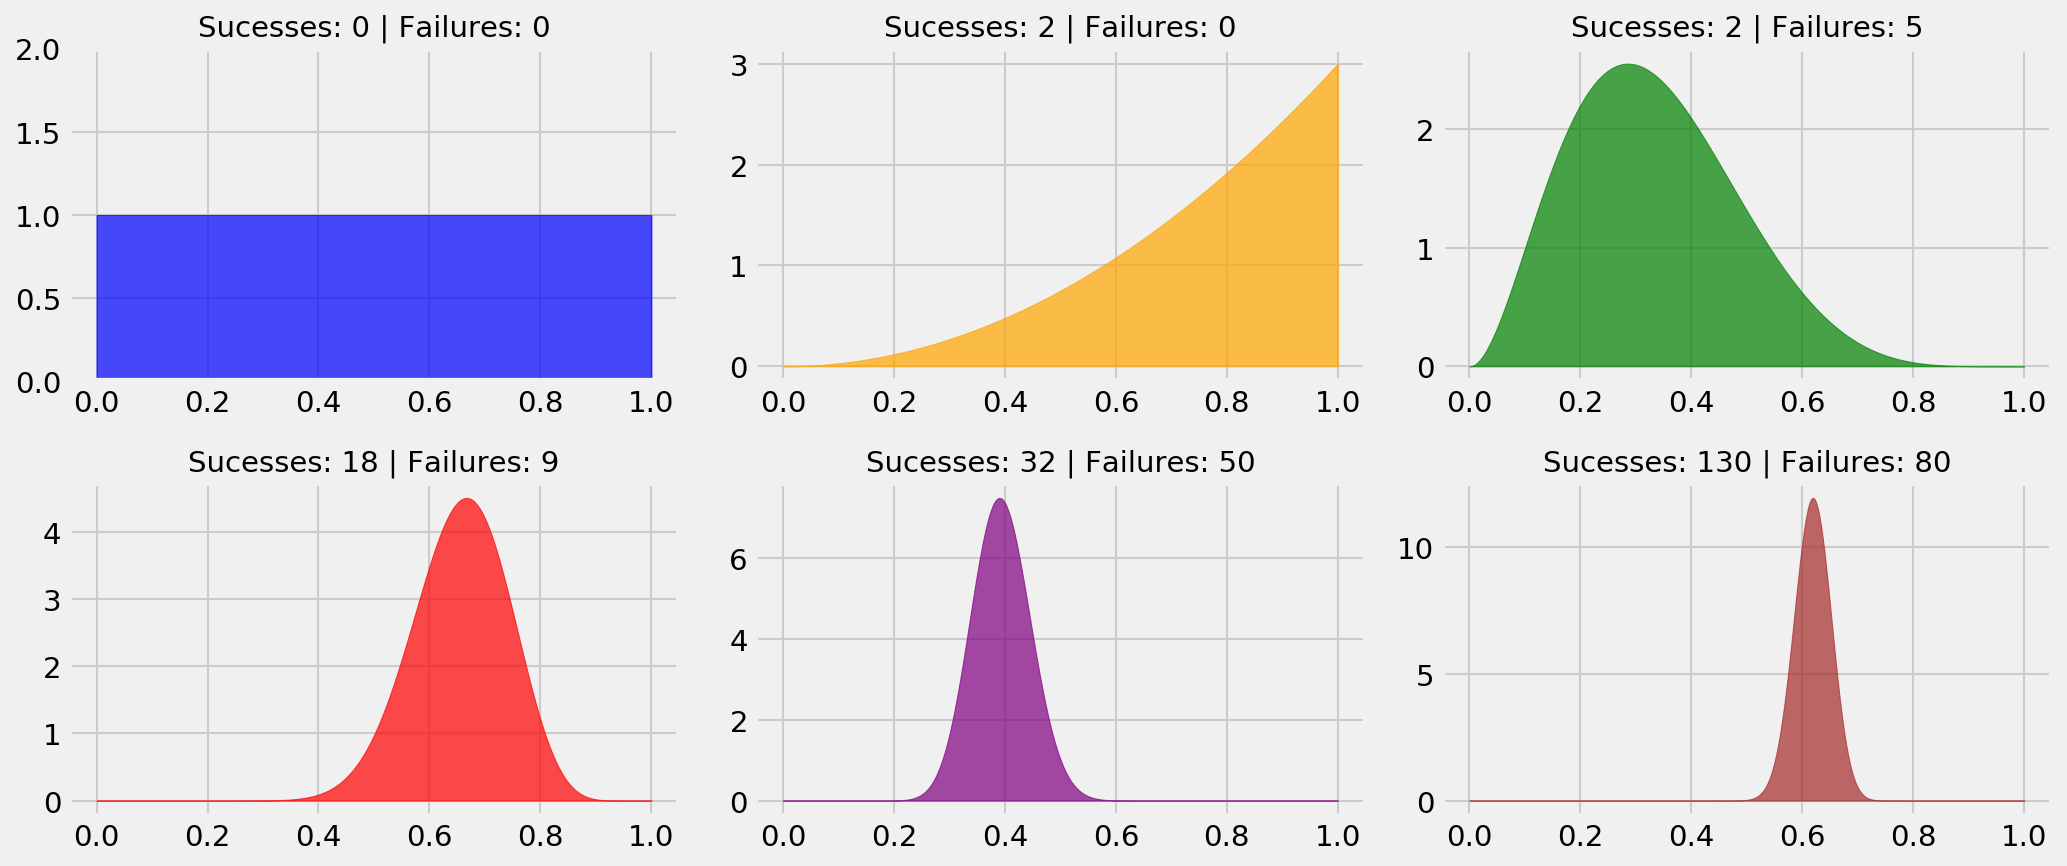

In [6]:
# clearing past figures
plt.close('all')

# examples 
beta_examples = [(0,0),(2,0),(2,5),(18,9),(32,50),(130,80)]

# colors for the plots
beta_colors = ['blue','orange','green','red','purple','brown']

# opening figure
fig, ax = plt.subplots(figsize=(14, 6), dpi=150, nrows=2, ncols=3)

# loop for each 
for i, example in enumerate(beta_examples):
    
    # points to sample for drawing the curve
    X = np.linspace(0,1,1000)
    
    # generating the curve
    dist = beta_dist(1 + example[0],1 + example[1])
    curve = dist.pdf(X)
    
    # plotly data
    ax[int(i/3)][(i % 3)].fill_between(X, 0, curve, color=beta_colors[i], alpha=0.7)
    ax[int(i/3)][(i % 3)].set_title('Sucesses: {} | Failures: {}'.format(example[0],example[1]), fontsize=14)

# some adjustments
ax[0][0].set(ylim=[0,2])
plt.tight_layout()
#plt.

# showing the figure
plt.show()

The interpretation is simple. In the blue plot, we haven't started playing, so the only thing we can say about the probability of a reward from the bandit is that it is uniform between 0 or 1. This is our initial guess for $\theta_k$, our **prior** distribution. In the orange plot, we played two times and received two rewards, so we start moving probability mass to the right side of the plot, as we have evidence that the probability of getting a reward is high. The distribution we get after updating our **prior** is the **posterior** distribution. In the green plot, we've played seven times and got two rewards, so our guess for $\theta_k$ is more biased towards the left-hand side.

As we play and gather evidence, our posterior distribution becomes more concentrated, as shown in the red, purple and brown plots. In the MAB setting, we calculate a posterior distribution for each bandit, at each round. Let us illustrate this.

In [7]:
# let us create a function that returns the pdf for our beta posteriors
def get_beta_pdf(alpha, beta):
    X = np.linspace(0,1,1000)
    return X, beta_dist(1 + alpha,1 + beta).pdf(X)

In [8]:
# for now, let us perform random draws
def random_policy(k_array, reward_array, n_bandits):
    return np.random.choice(range(n_bandits),1)[0]

In [24]:
# let us wrap a function that draws the draws and distributions of the bandit experiment
def plot_MAB_experiment(decision_policy, N_DRAWS, bandit_probs, plot_title):

    # clearing past figures
    plt.close('all')

    # number of bandits
    N_BANDITS = len(bandit_probs)
    
    # numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
    k_array = np.zeros((N_BANDITS,N_DRAWS))
    reward_array = np.zeros((N_BANDITS,N_DRAWS))
    
    # lists for accumulating draws, bandit choices and rewards
    k_list = []
    reward_list = []

    # animation dict for the posteriors
    posterior_anim_dict = {i:[] for i in range(N_BANDITS)}

    # opening figure
    fig = plt.figure(figsize=(9,5), dpi=150)

    # let us position our plots in a grid, the largest being our plays
    ax1 = plt.subplot2grid((5, 4), (0, 0), colspan=4, rowspan=3)
    ax2 = plt.subplot2grid((5, 4), (3, 0), rowspan=2)
    ax3 = plt.subplot2grid((5, 4), (3, 1), rowspan=2)
    ax4 = plt.subplot2grid((5, 4), (3, 2), rowspan=2)
    ax5 = plt.subplot2grid((5, 4), (3, 3), rowspan=2)

    # loop generating draws
    for draw_number in range(N_DRAWS):

        # record information about this draw
        k = decision_policy(k_array, reward_array, N_BANDITS)
        reward, regret = mab.draw(k)

        # record information about this draw
        k_list.append(k)
        reward_list.append(reward)
        k_array[k, draw_number] = 1
        reward_array[k, draw_number] = reward
        
        # sucesses and failures for our beta distribution
        success_count = reward_array.sum(axis=1)
        failure_count = k_array.sum(axis=1) - success_count
        
        # calculating pdfs for each bandit
        for bandit_id in range(N_BANDITS):

            # pdf
            X, curve = get_beta_pdf(success_count[bandit_id], failure_count[bandit_id])

            # appending to posterior animation dict
            posterior_anim_dict[bandit_id].append({'X': X, 'curve': curve})

        # getting list of colors that tells us the bandit
        color_list = [bandit_colors[k] for k in k_list]

        # getting list of facecolors that tells us the reward
        facecolor_list = [['none', bandit_colors[k_list[i]]][r] for i, r in enumerate(reward_list)]

    # fixing properties of the plots
    ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
    ax1.set_title(plot_title, fontsize=10)
    ax1.set_xlabel('Round', fontsize=10); ax1.set_ylabel('Bandit', fontsize=10)
    ax1.set_yticks([0,1,2,3])
    ax1.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, bandit_probs[i]) for i in range(4)])
    ax1.tick_params(labelsize=10)

    # titles of distribution plots
    ax2.set_title('Estimated $\\theta_0$', fontsize=10); ax3.set_title('Estimated $\\theta_1$', fontsize=10); 
    ax4.set_title('Estimated $\\theta_2$', fontsize=10); ax5.set_title('Estimated $\\theta_3$', fontsize=10);

    # initializing with first data
    scatter = ax1.scatter(y=[k_list[0]], x=[list(range(N_DRAWS))[0]], color=[color_list[0]], linestyle='-', marker='o', s=30, facecolor=[facecolor_list[0]]);
    dens1 = ax2.fill_between(posterior_anim_dict[0][0]['X'], 0, posterior_anim_dict[0][0]['curve'], color='red', alpha=0.7)
    dens2 = ax3.fill_between(posterior_anim_dict[1][0]['X'], 0, posterior_anim_dict[1][0]['curve'], color='green', alpha=0.7)
    dens3 = ax4.fill_between(posterior_anim_dict[2][0]['X'], 0, posterior_anim_dict[2][0]['curve'], color='blue', alpha=0.7)
    dens4 = ax5.fill_between(posterior_anim_dict[3][0]['X'], 0, posterior_anim_dict[3][0]['curve'], color='purple', alpha=0.7)

    # titles
    #plt.title('Random draws from the row of slot machines (MAB)', fontsize=10)
    #plt.xlabel('Round', fontsize=10); plt.ylabel('Bandit', fontsize=10);

    # function for updating
    def animate(i):

        # clearing axes
        ax1.clear(); ax2.clear(); ax3.clear(); ax4.clear(); ax5.clear();

        # updating game rounds
        scatter = ax1.scatter(y=k_list[:i], x=list(range(N_DRAWS))[:i], color=color_list[:i], 
                              linestyle='-', marker='o', s=30, facecolor=facecolor_list[:i]);

        # fixing properties of the plot
        ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
        ax1.set_title(plot_title, fontsize=10)
        ax1.set_xlabel('Round', fontsize=10); ax1.set_ylabel('Bandit', fontsize=10)
        ax1.set_yticks([0,1,2,3])
        ax1.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, bandit_probs[i]) for i in range(4)])
        ax1.tick_params(labelsize=10)

        # updating distributions
        dens1 = ax2.fill_between(posterior_anim_dict[0][i]['X'], 0, posterior_anim_dict[0][i]['curve'], color='red', alpha=0.7)
        dens2 = ax3.fill_between(posterior_anim_dict[1][i]['X'], 0, posterior_anim_dict[1][i]['curve'], color='green', alpha=0.7)
        dens3 = ax4.fill_between(posterior_anim_dict[2][i]['X'], 0, posterior_anim_dict[2][i]['curve'], color='blue', alpha=0.7)
        dens4 = ax5.fill_between(posterior_anim_dict[3][i]['X'], 0, posterior_anim_dict[3][i]['curve'], color='purple', alpha=0.7)

        # titles of distribution plots
        ax2.set_title('Estimated $\\theta_0$', fontsize=10); ax3.set_title('Estimated $\\theta_1$', fontsize=10); 
        ax4.set_title('Estimated $\\theta_2$', fontsize=10); ax5.set_title('Estimated $\\theta_3$', fontsize=10);
        
        # do not need to return 
        return ()

    # function for creating animation
    anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=200, blit=True)

    # fixing the layout
    fig.tight_layout()

    # showing
    return HTML(anim.to_html5_video())

In [25]:
# let us plot
plot_MAB_experiment(random_policy, 200, mab.bandit_probs, 'Random draws from the row of slot machines (MAB)')

The animation shows how the estimated probabilitites change as we play. Now, we can use this information to our benefit, in order to balance the uncertainty around our beliefs (exploration) with our objective of maximizing the cumulative reward (exploitation). Let us check how we can do this.

## The Exploitation/Exploration Tradeoff

Now that we know how to estimate probabilities for our bandits, we need to devise a method that can learn which machine to play (exploit) as fast as possible. Thus, we need to balance how many potentially sub-optimal plays we use to gain information about the system (explorarion) with how many plays we use to profit from the bandit we think is the best in the row (exploitation).

If we "waste" too many plays in random bandits just to gain knowledge, we lose cumulative reward. If we bet every play in a bandit that looked promising too soon, we can be stuck in a suboptimal strategy. 

This is what **Thompson Sampling** and other decision policies are all about. The balance of exploration and exploitation. Let us first study other two popular policies, so we can compare them with TS: **$\epsilon$-greedy** and **Upper Confidence Bound**.

### Mixing Random and Greedy Actions: $\epsilon$-greedy

The **$\epsilon$-greedy** policy is the simplest one. At each round, we select the best greedy action, but with $\epsilon$ probability, we select a random action (excluding the best greedy action).

In our case, the best greedy action is to select the bandit with the largest reward average, which is the one with the highest sample expected value $\textrm{argmax }\mathbf{E}[\theta_k]$. Let us implement this policy. 

In [11]:
# e-greedy policy
class eGreedyPolicy:
    
    # initializing
    def __init__(self, epsilon):
        
        # saving epsilon
        self.epsilon = epsilon
    
    # choice of bandit
    def choose_bandit(self, k_array, reward_array, n_bandits):
        
        # sucesses and total draws
        success_count = reward_array.sum(axis=1)
        total_count = k_array.sum(axis=1)
        
        # ratio of sucesses vs total
        success_ratio = success_count/total_count
        
        # choosing best greedy action or random depending with epsilon probability
        if np.random.random() < self.epsilon:
            
            # returning random action, excluding best
            return np.random.choice(np.delete(list(range(N_BANDITS)), np.argmax(success_ratio)))
        
        # else return best
        else:
            
            # returning best greedy action
            return np.argmax(success_ratio)    

In [33]:
# instance of this class, let us use 0.10 for the random action probability
e_greedy_policy = eGreedyPolicy(0.10)

In [34]:
# let us plot
plot_MAB_experiment(e_greedy_policy.choose_bandit, 200, mab.bandit_probs, '$\epsilon$-greedy decision policy: constant exploration and exploitation')

/home/gdmarmerola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


The $\epsilon$-greedy policy is our first step in trying to solve the bandit problem. It comes with a few caveats:

* **Addittion of a hyperaparameter:** we have to tune $\epsilon$ to make it work. In most cases this is not trivial.
* **Exploration is constant:** intuition tells us that we shold explore more in the beginning and exploit more as time passes. The $\epsilon$-greedy policy always explores at the same rate. In the long term, if $\epsilon$ is not reduced, we'll keep losing a great deal of rewards.
* **High risk of suboptimal decision:** if $\epsilon$ is low, we do not explore much, being under a high risk of being stuck in a suboptimal bandit for a long time.

Let us now try a solution which uses the uncertainty over our reward estimates: the Upper Confidence Bound policy.

### Optimism in the Face of Uncertainty: UCB

With the Upper Confidence Bound (UCB) policy we start using the uncertainty in our $\theta_k$ estimates to our benefit. The algorithm is as follows (UCB1 algorithm as stated [here](https://webdocs.cs.ualberta.ca/~games/go/seminar/notes/2007/slides_ucb.pdf)):

* For each action $j$ record the average reward $\overline{x_j}$ and number of times we have tried it $n_j$. We write $n$ for total number of actions we have tried.
* Try the action that maximises $\overline{x_j} + \sqrt{\frac{2\textrm{ln} n}{n_j}}$

The algorithm will pick the arm that has the maximum value at the upper confidence bound. It will balance exploration and exploitation since it will prefer less played arms which are promising. Let us implement it.

In [14]:
# e-greedy policy
class UCBPolicy:
    
    # initializing
    def __init__(self):
        
        # nothing to do here
        pass
    
    # choice of bandit
    def choose_bandit(self, k_array, reward_array, n_bandits):
        
        # sucesses and total draws
        success_count = reward_array.sum(axis=1)
        total_count = k_array.sum(axis=1)
        
        # ratio of sucesses vs total
        success_ratio = success_count/total_count
        
        # computing square root term
        sqrt_term = np.sqrt(2*np.log(np.sum(total_count))/total_count)
        
        # returning best greedy action
        return np.argmax(success_ratio + sqrt_term)    

In [15]:
# instance of UCB class
ucb_policy = UCBPolicy()

In [27]:
# let us plot'
plot_MAB_experiment(ucb_policy.choose_bandit, 200, mab.bandit_probs, 'UCB decision policy: using uncertainty and optimism')

/home/gdmarmerola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/gdmarmerola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/home/gdmarmerola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/gdmarmerola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/gdmarmerola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


We can note that exploration is fairly heavy in the beginning, with exploitation taking place further on the rounds. The algorithm quickly adapts whan a bandit becomes less promising, switching to another bandit with high optimistic estimate. Eventually, it will solve the bandit problem, as [it's regret is bounded](http://banditalgs.com/2016/09/18/the-upper-confidence-bound-algorithm/).

Now, for the last contender: Thompson Sampling!

### Probability matching: Thompson Sampling

The idea behind Thompson Sampling is the so-called **probability matching**. At each round, we want to pick a bandit with probability equal to the probability of it being the optimal choice. We emulate this behaviour in a very simple way:

* At each round, we calculate the distribution over the values of $\theta_k$, for each of the $K$ bandits.
* We take a single sample of each $\theta_k$ distributions, and pick the one with the largest value.

This algorithm is fairly old and did not receive much attention before [this publication](https://papers.nips.cc/paper/4321-an-empirical-evaluation-of-thompson-sampling.pdf) from Chapelle and Li, which showed strong empirical evidence of its efficiency. Let us try it for ourselves! 

In [17]:
# e-greedy policy
class TSPolicy:
    
    # initializing
    def __init__(self):
        
        # nothing to do here
        pass
    
    # choice of bandit
    def choose_bandit(self, k_array, reward_array, n_bandits):

        # list of samples, for each bandit
        samples_list = []
        
        # sucesses and failures
        success_count = reward_array.sum(axis=1)
        failure_count = k_array.sum(axis=1) - success_count
                    
        # drawing a sample from each bandit distribution
        samples_list = [np.random.beta(1 + success_count[bandit_id], 1 + failure_count[bandit_id]) for bandit_id in range(n_bandits)]
                                
        # returning bandit with best sample
        return np.argmax(samples_list)    

In [29]:
# instance of UCB class
ts_policy = TSPolicy()

In [30]:
# let us plot
plot_MAB_experiment(ts_policy.choose_bandit, 200, mab.bandit_probs, 'Thompson Sampling decision policy: probability matching')

We can see that Thompson Sampling performs a very efficient exploration, quickly ruling out less promising arms, but not quite greedily: less promising arms with high uncertainty are activated, as we do not have sufficient information to rule them out. However, when the distribution of the best arm stands out, with uncertainty considered, we get a lot more agressive on exploitation.

But let us not take conclusions from an illustrative example with only 200 rounds of play. Let us analyze cumulative rewards and regrets for each of our decision policies in many long-term simulations. 

## Regrets and cumulative rewards

We have observed small illustrative examples of our decision policies, which provided with interesting insights on how they work. Now, we're interested in measuring their behaviour in the long-term, after many rounds of play. Therefore, and also to make things fair and minimize the effect of randomness, we will perform many simulations of many rounds of play, and average the results per round across all simulations. Let us implement this. 

### Simulation

To keep things tidy, we perform the simulation in a separate subsection.

In [20]:
# number of rounds
N_ROUNDS = 10000

# number of simulations
N_SIMULATIONS = 1000

In [21]:
# dict storing each decision policy
dp_dict = {'e_greedy': e_greedy_policy.choose_bandit, 
           'ucb': ucb_policy.choose_bandit, 
           'ts': ts_policy.choose_bandit}

# dict storing results for each algorithm and simulation
results_dict = {'e_greedy': {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                             'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                             'regret_array': np.zeros((1,N_ROUNDS))[0]},
                'ucb':  {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                         'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                         'regret_array': np.zeros((1,N_ROUNDS))[0]},
                'ts':  {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                        'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                        'regret_array': np.zeros((1,N_ROUNDS))[0]}}

# loop for each algorithm
for key, decision_policy in dp_dict.items():
    
    # printing progress
    print(key, decision_policy)
    
    # loop for each simulation
    for simulation in tqdm(range(N_SIMULATIONS)):
        
        # numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
        k_array = np.zeros((N_BANDITS,N_ROUNDS))
        reward_array = np.zeros((N_BANDITS,N_ROUNDS))
        regret_array = np.zeros((1,N_ROUNDS))[0]
       
        # loop for each round
        for round_id in range(N_ROUNDS):

            # choosing arm nad pulling it
            k = decision_policy(k_array, reward_array, N_BANDITS)
            reward, regret = mab.draw(k)
            
            # record information about this draw
            k_array[k, round_id] = 1
            reward_array[k, round_id] = reward
            regret_array[round_id] = regret
            
        # results for the simulation
        results_dict[key]['k_array'] += k_array
        results_dict[key]['reward_array'] += reward_array
        results_dict[key]['regret_array'] += regret_array

  0%|          | 0/1000 [00:00<?, ?it/s]

e_greedy <bound method eGreedyPolicy.choose_bandit of <__main__.eGreedyPolicy object at 0x7fb0fe65feb8>>


/home/gdmarmerola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
  0%|          | 0/1000 [00:00<?, ?it/s]/home/gdmarmerola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/home/gdmarmerola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/gdmarmerola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/gdmarmerola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


ucb <bound method UCBPolicy.choose_bandit of <__main__.UCBPolicy object at 0x7fb0fe555eb8>>


  0%|          | 0/1000 [00:00<?, ?it/s]

ts <bound method TSPolicy.choose_bandit of <__main__.TSPolicy object at 0x7fb0fe922cc0>>


100%|██████████| 1000/1000 [11:28<00:00,  1.45it/s]


### Results

Let us now analyze the results. We're going to evaluate three things: (1) cumulative regret; (2) cumulative average rewards and (3) arm selection over time.

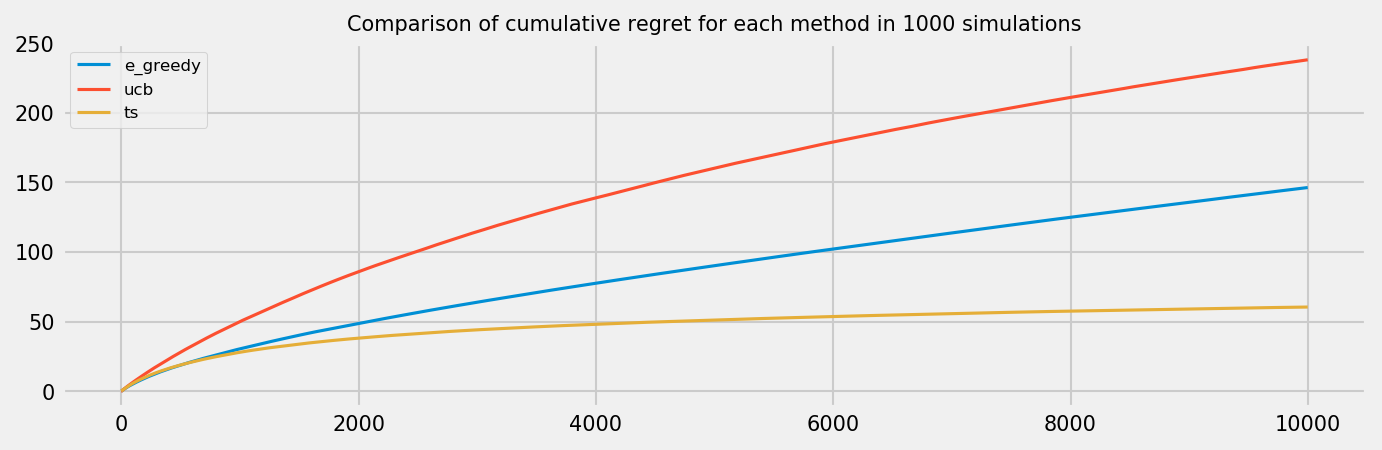

In [22]:
# closing all past figures
plt.close('all')

# opening figure to plot regret
plt.figure(figsize=(10, 3), dpi=150)

# loop for each decision policy
for policy in ['e_greedy','ucb','ts']:
    
    # plotting data
    plt.plot(np.cumsum(results_dict[policy]['regret_array']/N_SIMULATIONS), label=policy, linewidth=1.5);
    
# adding title
plt.title('Comparison of cumulative regret for each method in {} simulations'.format(N_SIMULATIONS), fontsize=10)

# adding legend
plt.legend(fontsize=8); plt.xticks(fontsize=10); plt.yticks(fontsize=10)

# showing plot
plt.show()

We see that Thompson sampling greatly outperforms the other methods. It is noteworthy that the $\epsilon$-greedy strategy has linear cumulative regret, as it is always selecting random actions. An improvement could be the $\epsilon$-decreasing strategy, at a cost of more complexity to tune the algorithm. This may not be practical, as Thompson Sampling show better performance but have no hyperparameters. The UCB policy, in our experiment, shows worse results than the $\epsilon$-greedy strategy. We could improve the policy by using the UCB2 algorithm instead of UCB1, or by using a hyperparameter to control how optimistic we are. Nevertheless, we expect that UCB will catch up to $\epsilon$-greedy after more rounds, as it will stop exploring eventually.

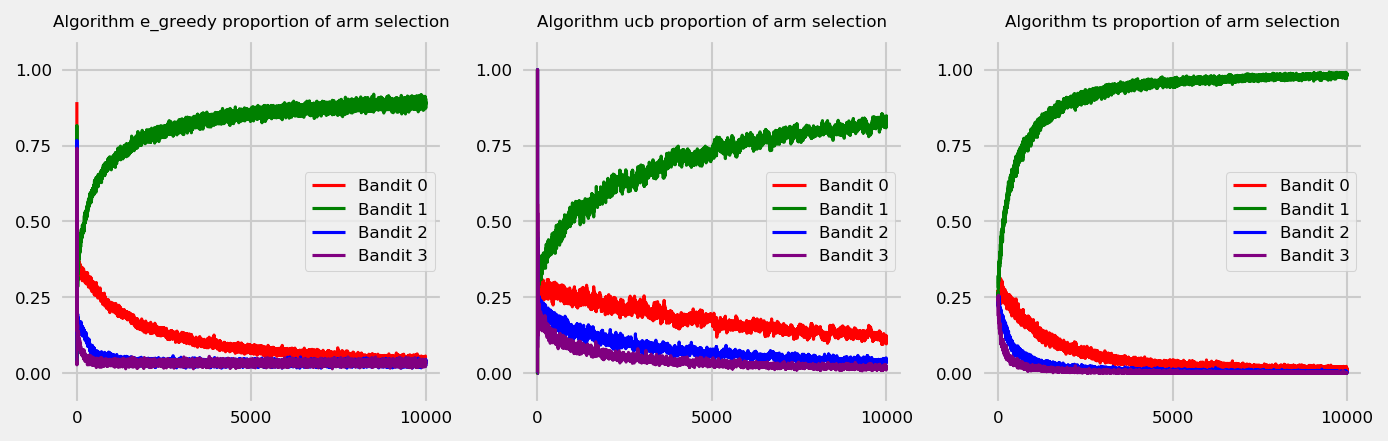

In [23]:
# closing all past figures
plt.close('all')

# opening figure to plot regret
plt.figure(figsize=(10, 3), dpi=150)

# colors for each bandit
bandit_colors = ['red', 'green', 'blue', 'purple']

# loop for each decision policy
for i, policy in enumerate(['e_greedy','ucb','ts']):
    
    # subplots
    plt.subplot(1,3,i+1)
    
    # loop for each arm
    for arm in range(N_BANDITS):
    
        # plotting data
        plt.plot(results_dict[policy]['k_array'][arm]/N_SIMULATIONS, label='Bandit {}'.format(arm), linewidth=1.5, color=bandit_colors[arm]);
    
        # adding title
        plt.title('Algorithm {} proportion of arm selection'.format(policy), fontsize=8)

        # adding legend
        plt.legend(fontsize=8); plt.xticks(fontsize=8); plt.yticks(fontsize=8); plt.ylim([-0.1,1.1])

# showing plot
plt.show()

We can see that Thompson Sampling has quick convergence to the optimal bandit, and also more stability across simulations. Let us wrap everything up and conclude.

## Conclusion

In this Notebook, we implemented the Multi-Armed Bandit problem and tested three decision policies to address the exploration/exploitation problem: (a) $\epsilon$-greedy, (b) UCB and (c) Thompson Sampling.

In order to implement these strategies and use them, we need to be bayesian and compute probability distributions over the parameters (the probabilities of reward, in this case) we're interested in. 

The $\epsilon$-greedy strategy uses a constant to balance exploration and exploitation. This is not ideal, as the hyperparameter may be hard to tune. Also, the exploration is done in 100% randomly, such that we explore bandits equally (in average), irrespective of how promising they may look.

The UCB strategy, unlike the $\epsilon$-greedy, uses the uncertainty of the posterior distribution to select the appropriate bandit at each round. It supposes that a bandit can be as good as it's reward distribution upper confidence bound. So we favor exploration by sampling from the distributions with high uncertainty and high tails, and exploit by sampling from the distribution with highest mean after we ruled out all the other upper confidence bounds.

Finally, Thompson Sampling uses a very elegant principle: to choose an action according to the probability of it being optimal. In practice, this makes for a very simple algorithm. We take one sample from each reward distribution, and choose the one with the highest value. Despite its simplicity, Thompson Sampling achieves state-of-the-art results, greatly outperforming the other algorithms. The logic is that it promotes efficient exploration: it explores more where it is promising, and quickly discards bad actions.